<a href="https://colab.research.google.com/github/tanupunjani/Mastering-tensorflow/blob/main/Transfer_learning_with_Tensorflow_part_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Are we using GPU ?
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#Get the data

In [ ]:
#Get data (10% of 10 food classs from Food101)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-08-07 23:59:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  56.7MB/s    in 2.8s    

2021-08-07 23:59:57 (56.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#How many images in each folder ?
import os

#Walk through the 10 percent data directory and list the number of files

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

#Creating data loaders (preparing the data)

In [ ]:
#Setup the data inputs

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image_shape = (224,224)
Batch_size = 32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                     target_size = Image_shape,
                                                     batch_size = Batch_size,
                                                     class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                          target_size = Image_shape,
                                          batch_size = Batch_size,
                                          class_mode = "categorical")



Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


#Setting up callbacks (things to run whilst our model trains)

#Callbacks are the extra functionality you can add to your models to be performed during or after training. These are the popular ones

* Tracking experiments with the tensorflow callbacks
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback 


In [ ]:
#Creating tensorflow callback (functionized because we need to create a new for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + datetime.datetime.now().strftime("%y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

> ### 🔑 **Note** :  You can customize the directory where your Tensorboard logs (model training metrics) get saved to whatever you like. the **log_dir** parameter is just an option here

#Creating models using tensorflow Hub 

In [ ]:
#Comparing two models

resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
#Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
#Lets create a creat_model() function to create a model from URL 

def create_model(model_url, num_classes=10):

  """
  Takes a Tensorflow Hub URL and creates a Keras sequential model with it.

  Args : 
    model_url(str): A Tensorflow Hub feature extraction URL.
    num_classes(int): Number of output neurons in the output layer,
    should be equal to the number of target classes, default 10.

    Returns : 
      An uncompiled Keras sequential model with model_url feature extracter layer and Dense output layer with num_classes output neurons.
  """

  #Download the pretrained model and save it as a Keras layer

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, #Freeze the already trained model
                                           name="feature_extraction_layer",
                                           input_shape=Image_shape+(3,))
  
  #Create our own model

  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
Image_shape + (3,)

(224, 224, 3)

#**Creating and testing ResNet Tensorflow Hub Feature Extraction model**

In [ ]:
# Create Resnet model 
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)


In [ ]:
#Compile the model 

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])



In [ ]:
#Fit the model to the 10 percent of 10 classes
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/210808-000009
Epoch 1/5
24/24 [==============================] - 423s 18s/step - loss: 1.8573 - accuracy: 0.3360 - val_loss: 1.1996 - val_accuracy: 0.6180
Epoch 2/5
24/24 [==============================] - 419s 18s/step - loss: 0.8999 - accuracy: 0.7253 - val_loss: 0.8799 - val_accuracy: 0.7112
Epoch 3/5
24/24 [==============================] - 416s 18s/step - loss: 0.6274 - accuracy: 0.8173 - val_loss: 0.7607 - val_accuracy: 0.7588
Epoch 4/5
24/24 [==============================] - 418s 18s/step - loss: 0.4757 - accuracy: 0.8880 - val_loss: 0.7056 - val_accuracy: 0.7728
Epoch 5/5
24/24 [==============================] - 419s 18s/step - loss: 0.3785 - accuracy: 0.9053 - val_loss: 0.6838 - val_accuracy: 0.7724


#This is amazing. The result that we have got with our 10 percent of the dataset and transfer learning is incredible. Lets plot our loss curves to visualize 

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

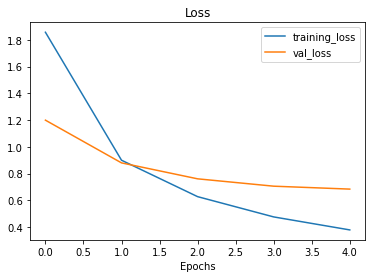

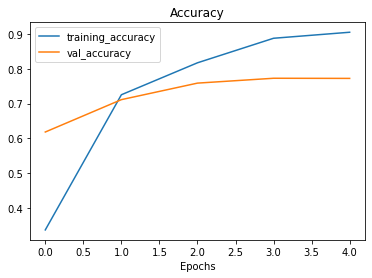

In [ ]:

plot_loss_curves(resnet_history)

# **Creating and testing the efficientnet model**

In [ ]:
# Create EfficinetNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=EfficientNet%2DB0%20is%20the%20baseline,than%20the%20best%20existing%20CNN.
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to : tensorflow_hub/210808-003603
Epoch 1/5
24/24 [==============================] - 192s 8s/step - loss: 1.8702 - accuracy: 0.4653 - val_loss: 1.2967 - val_accuracy: 0.7600
Epoch 2/5
24/24 [==============================] - 182s 8s/step - loss: 1.0569 - accuracy: 0.7853 - val_loss: 0.8631 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 182s 8s/step - loss: 0.7623 - accuracy: 0.8293 - val_loss: 0.6915 - val_accuracy: 0.8504
Epoch 4/5
24/24 [==============================] - 182s 8s/step - loss: 0.6076 - accuracy: 0.8600 - val_loss: 0.6048 - val_accuracy: 0.8624
Epoch 5/5
24/24 [==============================] - 182s 8s/step - loss: 0.5111 - accuracy: 0.8893 - val_loss: 0.5534 - val_accuracy: 0.8700


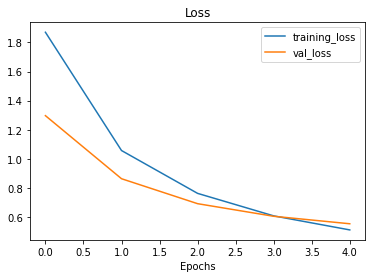

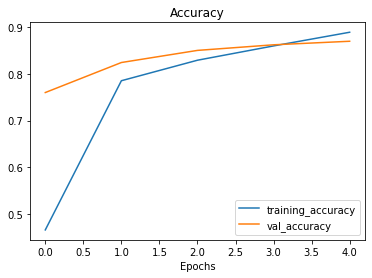

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#How many layers does our efficientnetb0 feature extractor have ?
len(efficientnet_model.layers[0].weights)

309

#Different types of transfer learning

* **"As is"** transfer learning - using existing model with no changes whatsover ( eg using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** - use the prelearned patterns of an existing model and adjust the output layer for your own problem
* **"Fine-tuning"** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including the output layers)

#Comparing our model's results with tensorboard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2021-08-07 23:58:49.385353: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2